# imports

In [12]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D,GlobalAveragePooling2D
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.utils import to_categorical
import seaborn as sns
from glob import glob
from PIL import Image
import matplotlib as mat
import matplotlib.pylab as plt
import matplotlib.image as mpimg
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from subprocess import check_output
import warnings
from os.path import split
from collections import Counter
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Data investigation

In [25]:
train_df = pd.read_csv("/home/abdlrhman/Desktop/MLND/my-capstone/dataset/train.csv")
train_df.describe()

,Image,Id
count,9850,9850
unique,9850,4251
top,cba74978.jpg,new_whale
freq,1,810


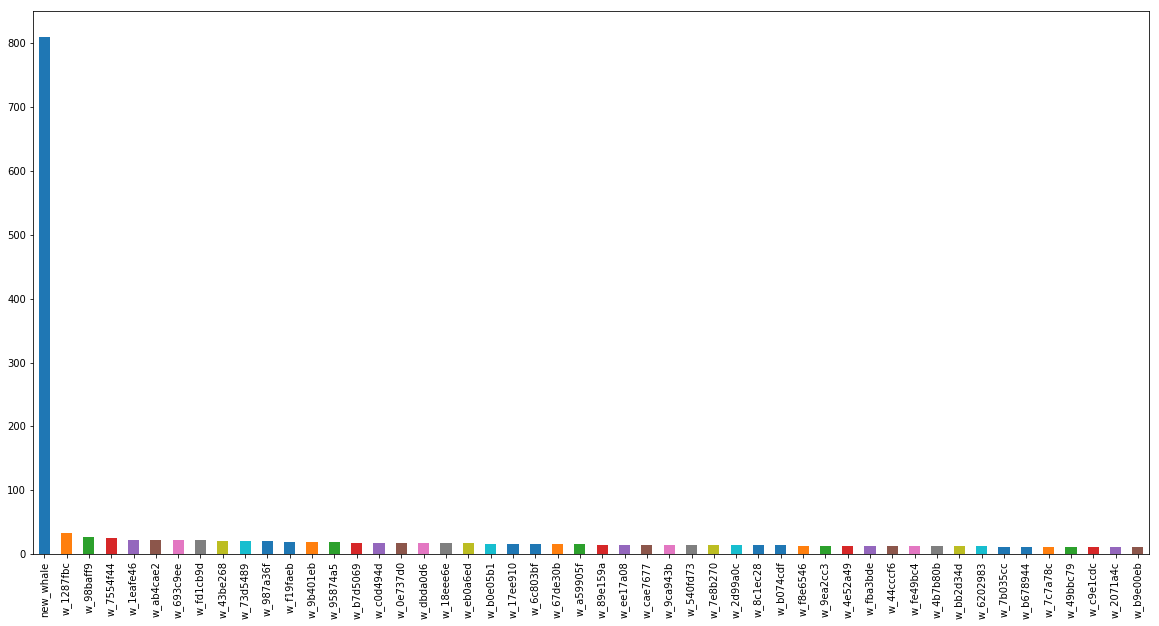

In [26]:
mat.rcParams["figure.figsize"] = 20, 10
train_df.Id.value_counts()[:50].plot(kind="bar")
plt.show()

 Most of the images belong to the new_whale 

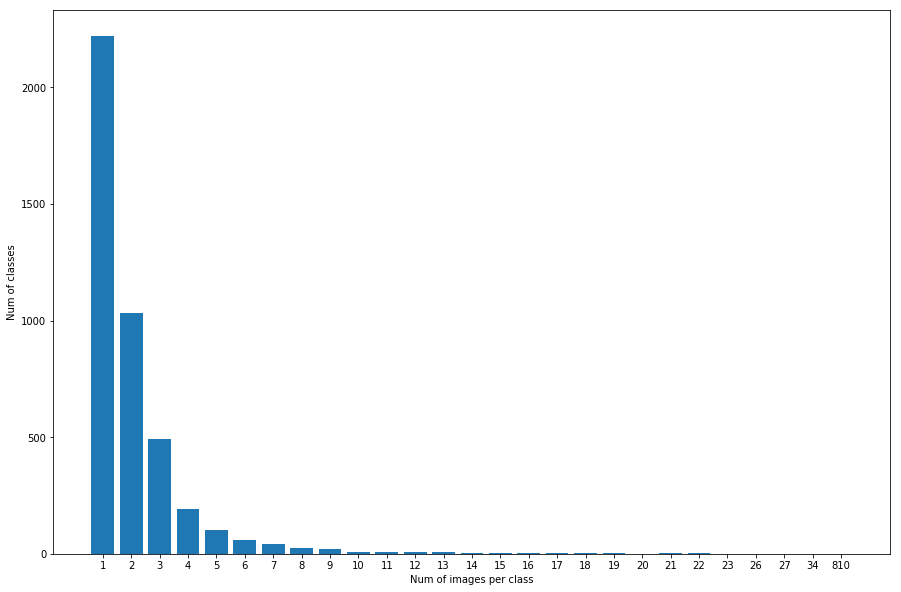

In [27]:
buckets = Counter(train_df['Id'].value_counts().values)
plt.figure(figsize=(15, 10))
plt.bar(range(len(buckets)), list(buckets.values())[::-1], align='center')
plt.xticks(range(len(buckets)), list(buckets.keys())[::-1])
plt.ylabel('Num of classes')
plt.xlabel('Num of images per class')
plt.show()

# Read the Images & Preprocess the images

In [40]:
train_images = train_df['Image'].tolist()
SIZE = 128
def ImportImage(filename):
    img = Image.open(filename).convert("LA").resize( (SIZE,SIZE))
    return np.array(img)[:,:,0]
X_train = np.array([ImportImage("dataset/train/"+img) for img in train_images])

In [41]:
# onehot encoding
Y_train = train_df['Id'].tolist()

ohe=OneHotEncoder()
encoder = LabelEncoder()
tmp_feas= encoder.fit_transform(Y_train)
Y_train=ohe.fit_transform(tmp_feas.reshape(-1,1)).toarray()


# Plot Some Samples

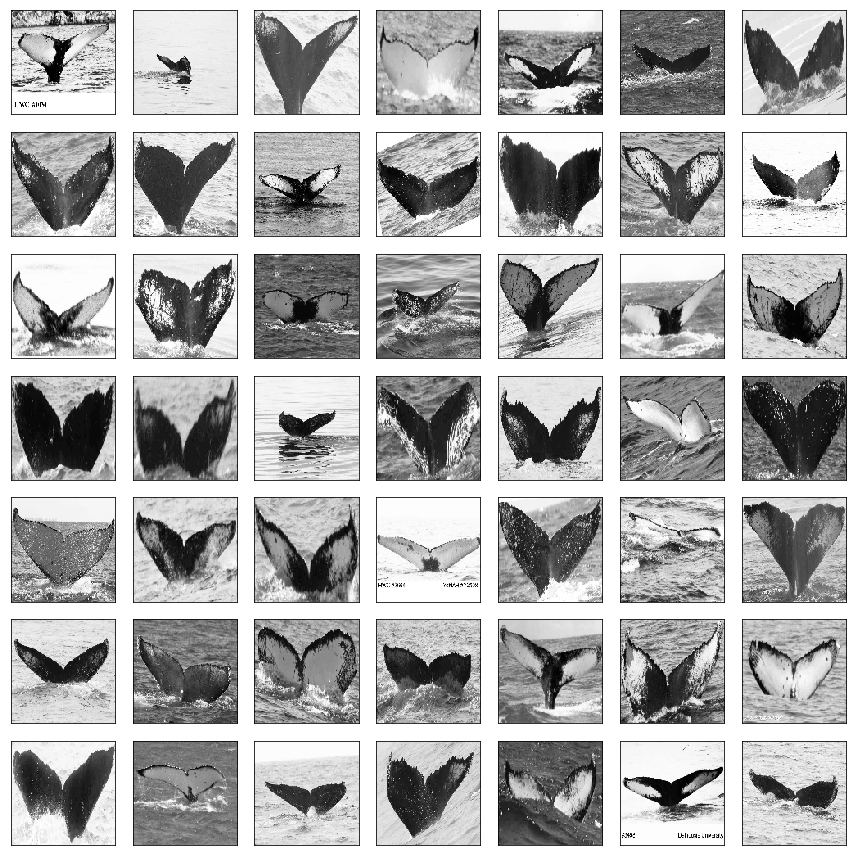

In [36]:
def plotImages( images_arr, n_images=7):
    fig, axes = plt.subplots(n_images, n_images, figsize=(12,12))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        if img.ndim != 2:
            img = img.reshape( (SIZE,SIZE))
        ax.imshow( img, cmap="Greys_r")
        ax.set_xticks(())
        ax.set_yticks(())
    plt.tight_layout()
    plt.savefig('سشة.png')
    
plotImages( X_train)


# Data Augmentation

In [37]:
X_train = X_train.reshape( (-1,SIZE,SIZE,1)).astype("float32")
N_CLASSES = len(Y_train[0])

image_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range = 0.05,
    shear_range=0.02,
    channel_shift_range=0.02,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

image_gen.fit(X_train, augment=True)

# the benchmark model

In [45]:
benchmark_model = Sequential()
benchmark_model.add(Conv2D(32, kernel_size=(7, 7),activation='relu',input_shape=X_train[0].shape, padding='same'))
benchmark_model.add(MaxPooling2D(pool_size=(2, 2)))
benchmark_model.add(Dropout(0.1))
benchmark_model.add(Conv2D(64, (4, 4), activation='relu', padding='same'))
benchmark_model.add(MaxPooling2D(pool_size=(2, 2)))
benchmark_model.add(Dropout(0.1))
benchmark_model.add(GlobalAveragePooling2D(data_format=None))
benchmark_model.add(Dense(N_CLASSES,activation='softmax'))

benchmark_model.compile(loss=keras.losses.categorical_crossentropy,optimizer='rmsprop',metrics=['accuracy'])
benchmark_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      1600      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        32832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

In [8]:
%%time
EPOCHS = 50
BATCH_SIZE = 128

benchmark_model.fit_generator(
    image_gen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
          steps_per_epoch=  (X_train.shape[0]//BATCH_SIZE),
          epochs=EPOCHS,
          verbose=1)

Epoch 1/50
76/76 [==============================] - 19s 251ms/step - loss: 8.1381 - acc: 0.0793
Epoch 2/50
76/76 [==============================] - 16s 215ms/step - loss: 7.8875 - acc: 0.0821
Epoch 3/50
76/76 [==============================] - 16s 215ms/step - loss: 7.8329 - acc: 0.0824
Epoch 4/50
76/76 [==============================] - 16s 214ms/step - loss: 7.8026 - acc: 0.0824
Epoch 5/50
76/76 [==============================] - 16s 214ms/step - loss: 7.7934 - acc: 0.0818
Epoch 6/50
76/76 [==============================] - 16s 213ms/step - loss: 7.7732 - acc: 0.0817
Epoch 7/50
76/76 [==============================] - 16s 214ms/step - loss: 7.7514 - acc: 0.0823
Epoch 8/50
76/76 [==============================] - 16s 214ms/step - loss: 7.7264 - acc: 0.0814
Epoch 9/50
76/76 [==============================] - 16s 214ms/step - loss: 7.6907 - acc: 0.0840
Epoch 10/50
76/76 [==============================] - 16s 213ms/step - loss: 7.6536 - acc: 0.0817
Epoch 11/50
76/76 [====================

In [9]:
benchmark_model.save_weights("benchmark_weights.hdf5")
benchmark_model.save("benchmark_model.hdf5")

# my Model

In [10]:
from keras.utils import plot_model

My_model = Sequential()
My_model.add(Conv2D(32, kernel_size=(7, 7),activation='relu',input_shape=X_train[0].shape, padding='same'))
My_model.add(MaxPooling2D(pool_size=(2, 2)))
My_model.add(Dropout(0.1))
My_model.add(Conv2D(64, (4, 4), activation='relu', padding='same'))
My_model.add(MaxPooling2D(pool_size=(2, 2)))
My_model.add(Dropout(0.1))
My_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
My_model.add(MaxPooling2D(pool_size=(2, 2)))
My_model.add(Dropout(0.1))
My_model.add(Conv2D(256, (2, 2), activation='relu', padding='same'))
My_model.add(MaxPooling2D(pool_size=(2, 2)))
My_model.add(Dropout(0.1))
My_model.add(AveragePooling2D(pool_size=(4, 4)))
My_model.add(Flatten())
My_model.add(Dense(512, activation='relu'))
My_model.add(Dropout(0.1))
My_model.add(Dense(256, activation='relu'))
My_model.add(Dropout(0.1))
My_model.add(Dense(N_CLASSES, activation='softmax'))

My_model.compile(loss=keras.losses.categorical_crossentropy,optimizer='rmsprop',metrics=['accuracy'])
My_model.summary()
plot_model(My_model, to_file='My_model.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 128, 128, 32)      1600      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 64)        32832     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 128)       73856     
__________

In [ ]:
%%time
EPOCHS = 20
BATCH_SIZE = 128

My_model.fit_generator(
    image_gen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
          steps_per_epoch=  (X_train.shape[0]//BATCH_SIZE),
          epochs=EPOCHS,
          verbose=1)

Epoch 1/20
76/76 [==============================] - 29s 378ms/step - loss: 8.2147 - acc: 0.0809
Epoch 2/20
76/76 [==============================] - 22s 291ms/step - loss: 7.8997 - acc: 0.0820
Epoch 3/20
76/76 [==============================] - 22s 291ms/step - loss: 7.8304 - acc: 0.0820
Epoch 4/20
76/76 [==============================] - 22s 291ms/step - loss: 7.7928 - acc: 0.0829
Epoch 5/20
76/76 [==============================] - 22s 290ms/step - loss: 7.7650 - acc: 0.0819
Epoch 6/20
76/76 [==============================] - 22s 290ms/step - loss: 7.6891 - acc: 0.0822
Epoch 7/20
76/76 [==============================] - 22s 290ms/step - loss: 7.5960 - acc: 0.0811
Epoch 8/20
76/76 [==============================] - 22s 290ms/step - loss: 7.5118 - acc: 0.0821
Epoch 9/20
76/76 [==============================] - 22s 289ms/step - loss: 7.4537 - acc: 0.0832
Epoch 10/20
76/76 [==============================] - 22s 290ms/step - loss: 7.3771 - acc: 0.0843
Epoch 11/20
76/76 [====================

In [9]:
My_model.save_weights("My_model_weights.hdf5")
My_model.save("My_model_model.hdf5")

# Test the models

In [38]:
benchmark_model = load_model("benchmark_model.hdf5")
benchmark_model.load_weights("benchmark_model.hdf5")
#My_model = load_model("My_model_model.hdf5")
#My_model.load_weights("My_model_weights.hdf5")

In [46]:
%%time

sample = pd.read_csv("/home/abdlrhman/Desktop/MLND/my-capstone/dataset/sample_submission.csv")

def generate_kaggle_submission_file(line):
    image = '/home/abdlrhman/Desktop/MLND/my-capstone/dataset/test/' + line[0]
    img = ImportImage( image)
    x = img.astype( "float32")
    x = image_gen.standardize( x.reshape(1,SIZE,SIZE))
    y = benchmark_model.predict_proba(x.reshape(1,SIZE,SIZE,1))
    predicted_args = np.argsort(y)[0][::-1][:5]
    predicted_tags = encoder.inverse_transform(predicted_args)
    #print (" ".join( predicted_tags))
    return " ".join( predicted_tags)

sample['Id'] = sample[['Image']].apply(generate_kaggle_submission_file, axis = 1)

SyntaxError: invalid syntax (<unknown>, line 13)

In [ ]:
sample.to_csv("benchmark_model-test.csv", index=False, header=True)